# Mount drive and import necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change the following path to match yours:

In [ ]:
%cd drive/MyDrive/Credit_card_fraud_test

[Errno 2] No such file or directory: 'drive/MyDrive/Credit_card_fraud_test'
/content/drive/MyDrive/Credit_card_fraud_test


In [ ]:
!ls

 creditcard.csv      divisibleNN.py	       __pycache__   utils.py
 Credit_card_fraud  'Project II Report.docx'   trainer.py


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from divisibleNN import DivisibleMLP
from trainer import Trainer
from utils import FocalLoss, MyDataset, plot_pr_curve

# Inspect the data

For this project, I use the Credit Card Fraud Detection from Kaggle. Credit card fraud is a typical 

In [ ]:
# Load the dataset
data = pd.read_csv('creditcard.csv')
# The time of record is irrelevant. We can drop this column.
data.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Percentage of negative class: 99.83%
Percentage of positive class: 0.17%


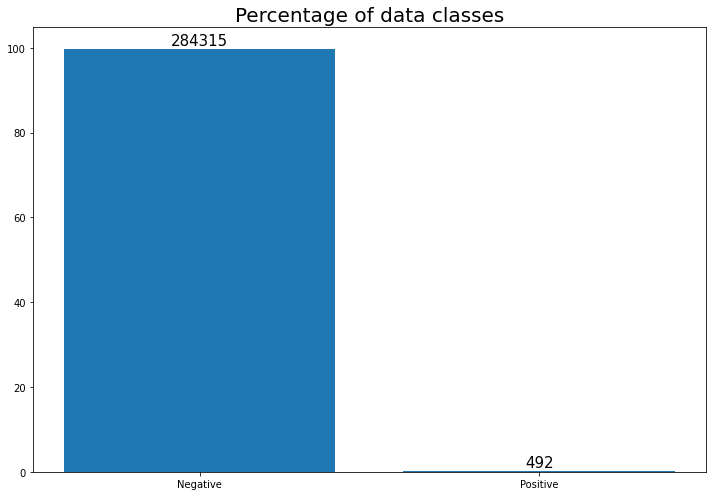

In [ ]:
sample_count = len(data)
negative_count = len(data[data['Class'] == 0])
positive_count = len(data[data['Class'] == 1])

print(f'Percentage of negative class: {negative_count/sample_count*100:.2f}%')
print(f'Percentage of positive class: {positive_count/sample_count*100:.2f}%')

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 7))
ax.set_title('Percentage of data classes', size=20)
ax.bar(('Negative', 'Positive'), (negative_count/sample_count*100, positive_count/sample_count*100), align='center')
count_iter = iter([negative_count, positive_count])
for bar in ax.patches:
  ax.annotate(str(next(count_iter)),
              (bar.get_x() + bar.get_width()/2, bar.get_height()),
              ha='center', va='center', size=15, xytext=(0, 8), textcoords='offset points')
plt.show()

# Hyperparameters

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NUM_EPOCHS = 5
ALPHA = torch.tensor([0.25, 1], dtype=torch.float, device='cuda')
GAMMA = 5

# Prepare data loaders

## Full dataset

In [ ]:
# Train, Dev, Test split
full_data = data.copy()
full_label = full_data.pop('Class')
data_train, data_test, label_train, label_test = train_test_split(full_data, full_label, test_size=0.2, stratify=full_label)
data_train, data_dev, label_train, label_dev = train_test_split(data_train, label_train, test_size=0.2, stratify=label_train)

In [ ]:
# Keep a separate copy of [data_train, data_dev] to use for under/over-sampling
train_copy = pd.concat([data_train, label_train], axis=1)
dev_copy = pd.concat([data_dev, label_dev], axis=1)

In [ ]:
# Create datasets
dataset_train = MyDataset(data_train, label_train)
dataset_dev = MyDataset(data_dev, label_dev)
dataset_test = MyDataset(data_test, label_test)

In [ ]:
# Create dataloaders
train_loader = DataLoader(dataset_train,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
dev_loader = DataLoader(dataset_dev,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
test_loader = DataLoader(dataset_test,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

[56864, 98]

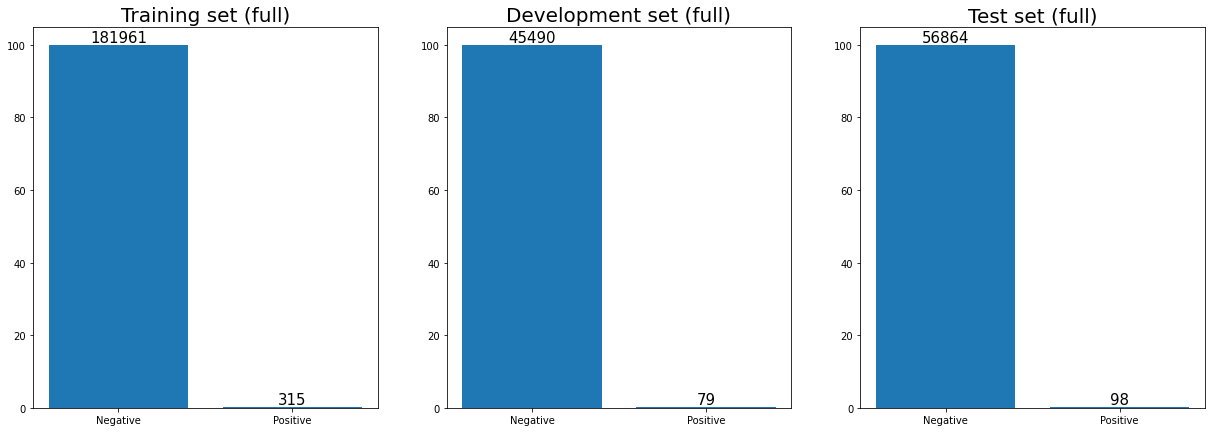

In [ ]:
fig = plt.figure(figsize=(21, 7))
ax_train = plt.subplot(1, 3, 1)
dataset_train.plot_percentage('Training set (full)', ('Negative', 'Positive'), ax_train)
ax_dev = plt.subplot(1, 3, 2)
dataset_dev.plot_percentage('Development set (full)', ('Negative', 'Positive'), ax_dev)
ax_test = plt.subplot(1, 3, 3)
dataset_test.plot_percentage('Test set (full)', ('Negative', 'Positive'), ax_test)

## Under-sampling dataset

In [ ]:
# Reduce negative samples
positive_train = train_copy[train_copy['Class']==1]
negative_train = train_copy[train_copy['Class']==0]
positive_dev = dev_copy[dev_copy['Class']==1]
negative_dev = dev_copy[dev_copy['Class']==0]
i1 = random.randint(0, len(negative_train)-len(positive_train))
under_data_train = pd.concat([positive_train, negative_train.iloc[i1:i1+len(positive_train), :]])
under_label_train = under_data_train.pop('Class')
i2 = random.randint(0, len(negative_dev)-len(positive_dev))
under_data_dev = pd.concat([positive_dev, negative_dev.iloc[i2:i2+len(positive_dev), :]])
under_label_dev = under_data_dev.pop('Class')

In [ ]:
# Create datasets
under_dataset_train = MyDataset(under_data_train, under_label_train)
under_dataset_dev = MyDataset(under_data_dev, under_label_dev)

In [ ]:
# Create dataloaders
under_train_loader = DataLoader(under_dataset_train,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
under_dev_loader = DataLoader(under_dataset_dev,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

[79, 79]

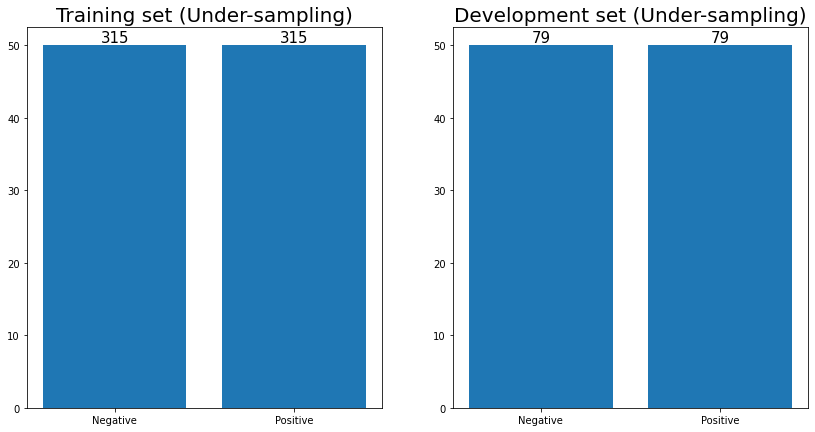

In [ ]:
fig = plt.figure(figsize=(14, 7))
ax_us_train = plt.subplot(1, 2, 1)
under_dataset_train.plot_percentage('Training set (Under-sampling)', ('Negative', 'Positive'), ax_us_train)
ax_us_dev = plt.subplot(1, 2, 2)
under_dataset_dev.plot_percentage('Development set (Under-sampling)', ('Negative', 'Positive'), ax_us_dev)

## Over-sampling dataset

In [ ]:
# Duplicate positive samples
positive_train = train_copy[train_copy['Class']==1]
negative_train = train_copy[train_copy['Class']==0]
positive_dev = dev_copy[dev_copy['Class']==1]
negative_dev = dev_copy[dev_copy['Class']==0]
positive_train_over = pd.concat([positive_train]*(round(len(negative_train)/len(positive_train))))
positive_dev_over = pd.concat([positive_dev]*(round(len(negative_dev)/len(positive_dev))))
over_data_train = pd.concat([positive_train_over, negative_train])
over_data_dev = pd.concat([positive_dev_over, negative_dev])
over_label_train = over_data_train.pop('Class')
over_label_dev = over_data_dev.pop('Class')

In [ ]:
# Create datasets
over_dataset_train = MyDataset(over_data_train, over_label_train)
over_dataset_dev = MyDataset(over_data_dev, over_label_dev)

In [ ]:
# Create dataloaders
over_train_loader = DataLoader(over_dataset_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
over_dev_loader = DataLoader(over_dataset_dev,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

[45490, 45504]

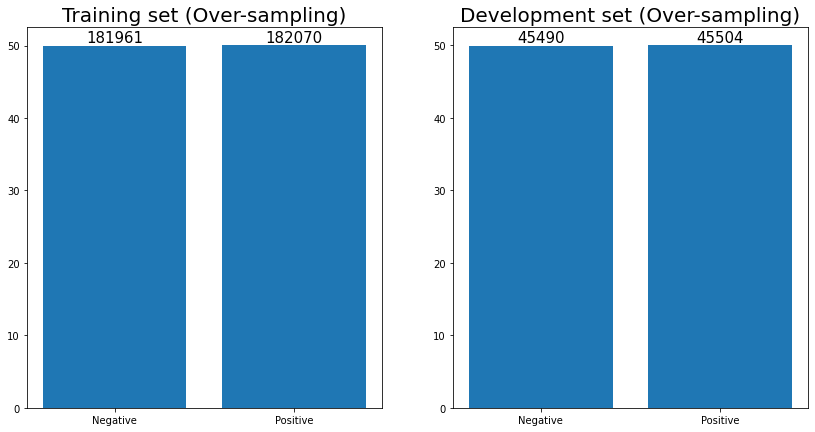

In [ ]:
fig = plt.figure(figsize=(14, 7))
ax_os_train = plt.subplot(1, 2, 1)
over_dataset_train.plot_percentage('Training set (Over-sampling)', ('Negative', 'Positive'), ax_os_train)
ax_os_dev = plt.subplot(1, 2, 2)
over_dataset_dev.plot_percentage('Development set (Over-sampling)', ('Negative', 'Positive'), ax_os_dev)

# Experiments

## Under-sampling

[79, 79]

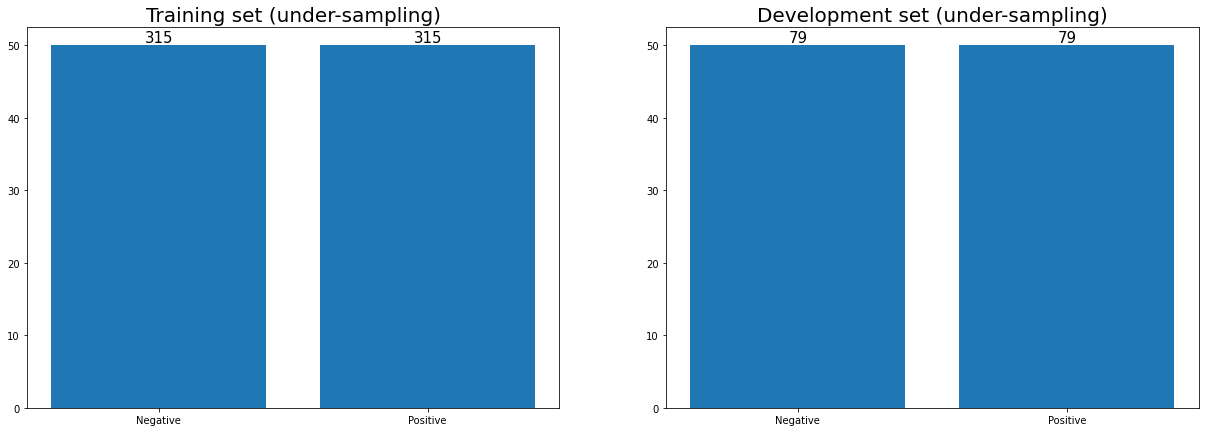

In [ ]:
us_fig = plt.figure(figsize=(21, 7))
ax_us_train = plt.subplot(1, 2, 1)
under_dataset_train.plot_percentage('Training set (under-sampling)', ('Negative', 'Positive'), ax_us_train)
ax_us_dev = plt.subplot(1, 2, 2)
under_dataset_dev.plot_percentage('Development set (under-sampling)', ('Negative', 'Positive'), ax_us_dev)

In [ ]:
us_model = DivisibleMLP(29, 2, device='cuda')
us_model.init_params_state()
criterion_us = torch.nn.NLLLoss()
trainer_us = Trainer(us_model)

In [ ]:
trainer_us.train(under_train_loader, criterion_us, under_dev_loader, epochs=50,
                 learning_rate=LEARNING_RATE, steps=1, freeze_neurons=False)

Training epoch: 1...
Epoch: 1 [0/630 (0%)]	Train Loss: 0.69337
Epoch: 1 [128/630 (20%)]	Train Loss: 0.70697
Epoch: 1 [256/630 (40%)]	Train Loss: 0.70782
Epoch: 1 [384/630 (60%)]	Train Loss: 0.67860
Epoch: 1 [512/630 (80%)]	Train Loss: 0.67420
********** TRAIN_LOSS = 0.69219 **********
********** TRAIN_ACC = 60.95% ************
Finished training epoch 1

Training epoch: 2...
Epoch: 2 [0/630 (0%)]	Train Loss: 0.66297
Epoch: 2 [128/630 (20%)]	Train Loss: 0.66273
Epoch: 2 [256/630 (40%)]	Train Loss: 0.65276
Epoch: 2 [384/630 (60%)]	Train Loss: 0.73026
Epoch: 2 [512/630 (80%)]	Train Loss: 0.64715
********** TRAIN_LOSS = 0.67118 **********
********** TRAIN_ACC = 59.37% ************
Finished training epoch 2

Training epoch: 3...
Epoch: 3 [0/630 (0%)]	Train Loss: 0.66273
Epoch: 3 [128/630 (20%)]	Train Loss: 0.64398
Epoch: 3 [256/630 (40%)]	Train Loss: 0.77241
Epoch: 3 [384/630 (60%)]	Train Loss: 0.61712
Epoch: 3 [512/630 (80%)]	Train Loss: 0.63360
********** TRAIN_LOSS = 0.66597 **********
**

In [ ]:
with torch.no_grad():
  y_pred = us_model(dataset_test.data.to('cuda'))
  y_pred = torch.argmax(y_pred, dim=1)
print(classification_report(dataset_test.label, y_pred.cpu().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9999    0.9618    0.9805     56864
           1     0.0406    0.9388    0.0778        98

    accuracy                         0.9617     56962
   macro avg     0.5202    0.9503    0.5291     56962
weighted avg     0.9982    0.9617    0.9789     56962



## Over-sampling

[45490, 45504]

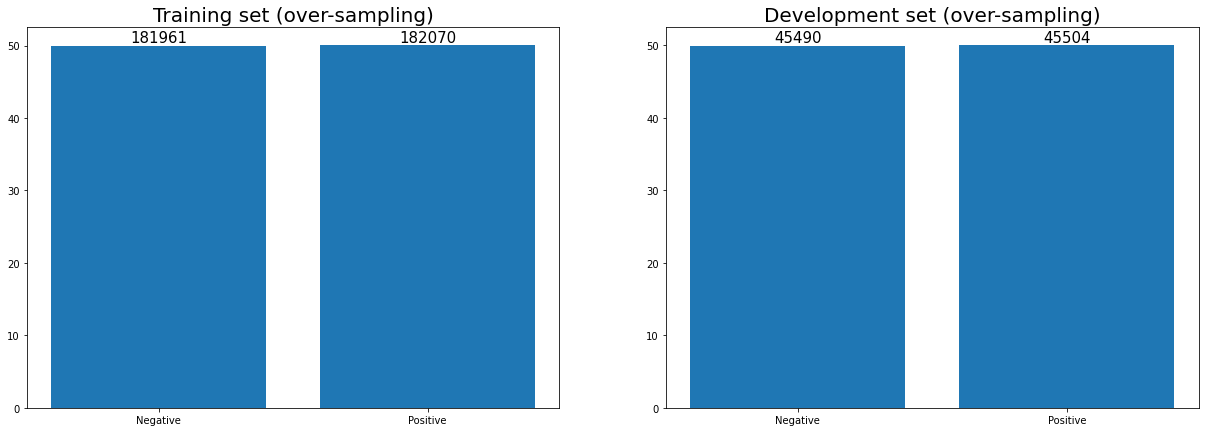

In [ ]:
os_fig = plt.figure(figsize=(21, 7))
ax_os_train = plt.subplot(1, 2, 1)
over_dataset_train.plot_percentage('Training set (over-sampling)', ('Negative', 'Positive'), ax_os_train)
ax_os_dev = plt.subplot(1, 2, 2)
over_dataset_dev.plot_percentage('Development set (over-sampling)', ('Negative', 'Positive'), ax_os_dev)

In [ ]:
os_model = DivisibleMLP(29, 2, device='cuda')
os_model.init_params_state()
criterion_os = torch.nn.NLLLoss()
trainer_os = Trainer(os_model)

In [ ]:
trainer_os.train(over_train_loader, criterion_os, over_dev_loader, epochs=NUM_EPOCHS,
                 learning_rate=LEARNING_RATE, steps=100, freeze_neurons=False)

Training epoch: 1...
Epoch: 1 [0/364031 (0%)]	Train Loss: 0.73700
Epoch: 1 [12800/364031 (4%)]	Train Loss: 0.33110
Epoch: 1 [25600/364031 (7%)]	Train Loss: 0.12147
Epoch: 1 [38400/364031 (11%)]	Train Loss: 0.12349
Epoch: 1 [51200/364031 (14%)]	Train Loss: 0.08175
Epoch: 1 [64000/364031 (18%)]	Train Loss: 0.16085
Epoch: 1 [76800/364031 (21%)]	Train Loss: 0.12044
Epoch: 1 [89600/364031 (25%)]	Train Loss: 0.09990
Epoch: 1 [102400/364031 (28%)]	Train Loss: 0.07088
Epoch: 1 [115200/364031 (32%)]	Train Loss: 0.07232
Epoch: 1 [128000/364031 (35%)]	Train Loss: 0.09348
Epoch: 1 [140800/364031 (39%)]	Train Loss: 0.07764
Epoch: 1 [153600/364031 (42%)]	Train Loss: 0.14253
Epoch: 1 [166400/364031 (46%)]	Train Loss: 0.03738
Epoch: 1 [179200/364031 (49%)]	Train Loss: 0.07011
Epoch: 1 [192000/364031 (53%)]	Train Loss: 0.06283
Epoch: 1 [204800/364031 (56%)]	Train Loss: 0.03396
Epoch: 1 [217600/364031 (60%)]	Train Loss: 0.03917
Epoch: 1 [230400/364031 (63%)]	Train Loss: 0.20283
Epoch: 1 [243200/364031 (

In [ ]:
with torch.no_grad():
  y_pred = os_model(dataset_test.data.to('cuda'))
  y_pred = torch.argmax(y_pred, dim=1)
print(classification_report(dataset_test.label, y_pred.cpu().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9978    0.9988     56864
           1     0.4038    0.8571    0.5490        98

    accuracy                         0.9976     56962
   macro avg     0.7018    0.9275    0.7739     56962
weighted avg     0.9987    0.9976    0.9980     56962



## Focal loss

In [ ]:
fl_model = DivisibleMLP(29, 2, device='cuda')
fl_model.init_params_state()
criterion_fl = FocalLoss(gamma=GAMMA, alpha=ALPHA, reduction='mean')
trainer_fl = Trainer(fl_model)

In [ ]:
trainer_fl.train(train_loader, criterion_fl, dev_loader, epochs=NUM_EPOCHS,
                 learning_rate=LEARNING_RATE, steps=100, freeze_neurons=False)

Training epoch: 1...
Epoch: 1 [0/182276 (0%)]	Train Loss: 0.01070
Epoch: 1 [12800/182276 (7%)]	Train Loss: 0.00004
Epoch: 1 [25600/182276 (14%)]	Train Loss: 0.00012
Epoch: 1 [38400/182276 (21%)]	Train Loss: 0.00000
Epoch: 1 [51200/182276 (28%)]	Train Loss: 0.00000
Epoch: 1 [64000/182276 (35%)]	Train Loss: 0.00000
Epoch: 1 [76800/182276 (42%)]	Train Loss: 0.00000
Epoch: 1 [89600/182276 (49%)]	Train Loss: 0.00000
Epoch: 1 [102400/182276 (56%)]	Train Loss: 0.00000
Epoch: 1 [115200/182276 (63%)]	Train Loss: 0.00000
Epoch: 1 [128000/182276 (70%)]	Train Loss: 0.00000
Epoch: 1 [140800/182276 (77%)]	Train Loss: 0.00000
Epoch: 1 [153600/182276 (84%)]	Train Loss: 0.00000
Epoch: 1 [166400/182276 (91%)]	Train Loss: 0.00001
Epoch: 1 [179200/182276 (98%)]	Train Loss: 0.00000
********** TRAIN_LOSS = 0.00026 **********
********** TRAIN_ACC = 99.89% ************
Finished training epoch 1

Training epoch: 2...
Epoch: 2 [0/182276 (0%)]	Train Loss: 0.00002
Epoch: 2 [12800/182276 (7%)]	Train Loss: 0.00000


In [ ]:
with torch.no_grad():
  y_pred = fl_model(dataset_test.data.to('cuda'))
  y_pred = torch.argmax(y_pred, dim=1)
print(classification_report(dataset_test.label, y_pred.cpu().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8795    0.7449    0.8066        98

    accuracy                         0.9994     56962
   macro avg     0.9395    0.8724    0.9032     56962
weighted avg     0.9994    0.9994    0.9994     56962



## Proposed method

In [ ]:
model = DivisibleMLP(29, 2, device='cuda')
model.init_params_state()
criterion = torch.nn.NLLLoss()
trainer = Trainer(model)

In [ ]:
trainer.train(under_train_loader, criterion, under_dev_loader, epochs=200,
              learning_rate=LEARNING_RATE, steps=1, high=0.85, low=0.15)
trainer.train(train_loader, criterion, dev_loader, epochs=5,
              learning_rate=LEARNING_RATE, steps=100, high=5, low=0.1)

Training epoch: 1...
Epoch: 1 [0/630 (0%)]	Train Loss: 0.79902
Epoch: 1 [128/630 (20%)]	Train Loss: 0.72437
Epoch: 1 [256/630 (40%)]	Train Loss: 0.74315
Epoch: 1 [384/630 (60%)]	Train Loss: 0.69092
Epoch: 1 [512/630 (80%)]	Train Loss: 0.68134
********** TRAIN_LOSS = 0.72776 **********
********** TRAIN_ACC = 53.17% ************
***Beginning freezing neurons...***
Nothing has been frozen
Finished training epoch 1

Training epoch: 2...
Epoch: 2 [0/630 (0%)]	Train Loss: 0.67942
Epoch: 2 [128/630 (20%)]	Train Loss: 0.66437
Epoch: 2 [256/630 (40%)]	Train Loss: 0.70323
Epoch: 2 [384/630 (60%)]	Train Loss: 0.66926
Epoch: 2 [512/630 (80%)]	Train Loss: 0.73794
********** TRAIN_LOSS = 0.69084 **********
********** TRAIN_ACC = 67.62% ************
***Beginning freezing neurons...***
Nothing has been frozen
Finished training epoch 2

Training epoch: 3...
Epoch: 3 [0/630 (0%)]	Train Loss: 0.65660
Epoch: 3 [128/630 (20%)]	Train Loss: 0.78960
Epoch: 3 [256/630 (40%)]	Train Loss: 0.63525
Epoch: 3 [384/6

In [ ]:
with torch.no_grad():
  y_pred = model(dataset_test.data.to('cuda'))
  y_pred = torch.argmax(y_pred, dim=1)
print(classification_report(dataset_test.label, y_pred.cpu().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8977    0.8061    0.8495        98

    accuracy                         0.9995     56962
   macro avg     0.9487    0.9030    0.9246     56962
weighted avg     0.9995    0.9995    0.9995     56962



## Comparison

Text(0.5, 0, 'Recall')

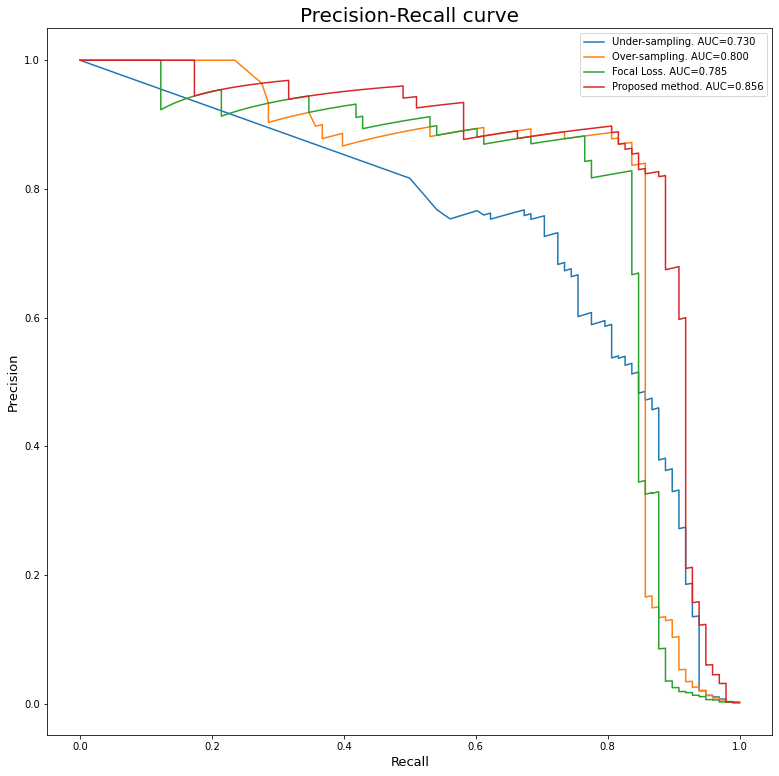

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
us_line, us_auc = plot_pr_curve(us_model, dataset_test, ax=ax, title=None)
os_line, os_auc = plot_pr_curve(os_model, dataset_test, ax=ax, title=None)
fl_line, fl_auc = plot_pr_curve(fl_model, dataset_test, ax=ax, title=None)
line, auc = plot_pr_curve(model, dataset_test, ax=ax, title=None)
us_line.set_label(f'Under-sampling. AUC={us_auc:.3f}')
os_line.set_label(f'Over-sampling. AUC={os_auc:.3f}')
fl_line.set_label(f'Focal Loss. AUC={fl_auc:.3f}')
line.set_label(f'Proposed method. AUC={auc:.3f}')
ax.legend()
ax.set_title('Precision-Recall curve', size=20)
ax.set_ylabel('Precision', size=13)
ax.set_xlabel('Recall', size=13)